**IMDB Movie Reviews using sentiment analysis**

In [127]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import spacy

In [128]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
#Lets load the dataset from drive (downloaded from Kaggle)
df = pd.read_csv('/content/drive/MyDrive/Datasets/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [130]:
reviews = df['review']
reviews = reviews.replace({'<.*?>': ''}, regex = True)          # remove html tag
sentiments = df['sentiment']
sentiment_mapping = {'positive': 1, 'negative': 0}
#Converting sentiment into numeric form
sentiments_encoded = sentiments.map(sentiment_mapping)
# print(reviews)
# print(sentiments_encoded)

In [131]:
##Preprocessing by stemming
stemmer = PorterStemmer()
nltk.download('punkt')
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

#Example
print(preprocess_text("This is an example sentence."))

thi is an exampl sentenc .


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [132]:
#Spacy way of preprocessing
nlp = spacy.load('en_core_web_sm')
def preprocess_text_spacy(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

In [134]:
spacy_preprocessed_reviews = [preprocess_text_spacy(review) for review in reviews]

In [159]:
spacy_preprocessed_reviews_lower = [review.lower() for review in spacy_preprocessed_reviews]

In [160]:
#Lets now bring the data
X_train, X_test, y_train, y_test = train_test_split(spacy_preprocessed_reviews_lower, sentiments_encoded, test_size=0.2, random_state=42)

In [161]:
#Now Tokenize and vectorize training text to do embedding
tokenizer = Tokenizer(oov_token='<OOV>')
max_sequence_length = 200
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


In [162]:
#Embedding
embedding_dim = 100
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length)
sentences = [review.split() for review in X_train]
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [163]:
def train_model(epochs, batch_size,lstm_units):
  # Build the LSTM model
  model = Sequential()
  model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
  model.add(LSTM(lstm_units))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model
  history=model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,verbose=1)
  return model,history

In [164]:
model,history= train_model(epochs=10, batch_size=32,lstm_units=128)

Epoch 1/10
1000/1000 [==============================] - 13s 11ms/step - loss: 0.3636 - accuracy: 0.8393 - val_loss: 0.3052 - val_accuracy: 0.8694
Epoch 2/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2885 - accuracy: 0.8797 - val_loss: 0.2813 - val_accuracy: 0.8788
Epoch 3/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2574 - accuracy: 0.8942 - val_loss: 0.2681 - val_accuracy: 0.8860
Epoch 4/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2309 - accuracy: 0.9052 - val_loss: 0.2680 - val_accuracy: 0.8894
Epoch 5/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2061 - accuracy: 0.9173 - val_loss: 0.2732 - val_accuracy: 0.8873
Epoch 6/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1790 - accuracy: 0.9294 - val_loss: 0.2823 - val_accuracy: 0.8826
Epoch 7/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1415 - accuracy: 0.9465 - val_loss: 0.3264 -

In [165]:
#Lets now check the model accuracy on test data
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

313/313 [==============================] - 3s 7ms/step - loss: 0.4338 - accuracy: 0.8753
Test Loss: 0.43384233117103577
Test Accuracy: 0.8752999901771545


In [166]:
#Lets save the history
import pickle

with open('/content/drive/My Drive/imbd_senti_analysis_spacy_model_history.pkl', 'wb') as file:
    pickle.dump(history, file)


In [167]:
#Lets save it now
model.save('/content/drive/My Drive/imbd_senti_analysis_spacy_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


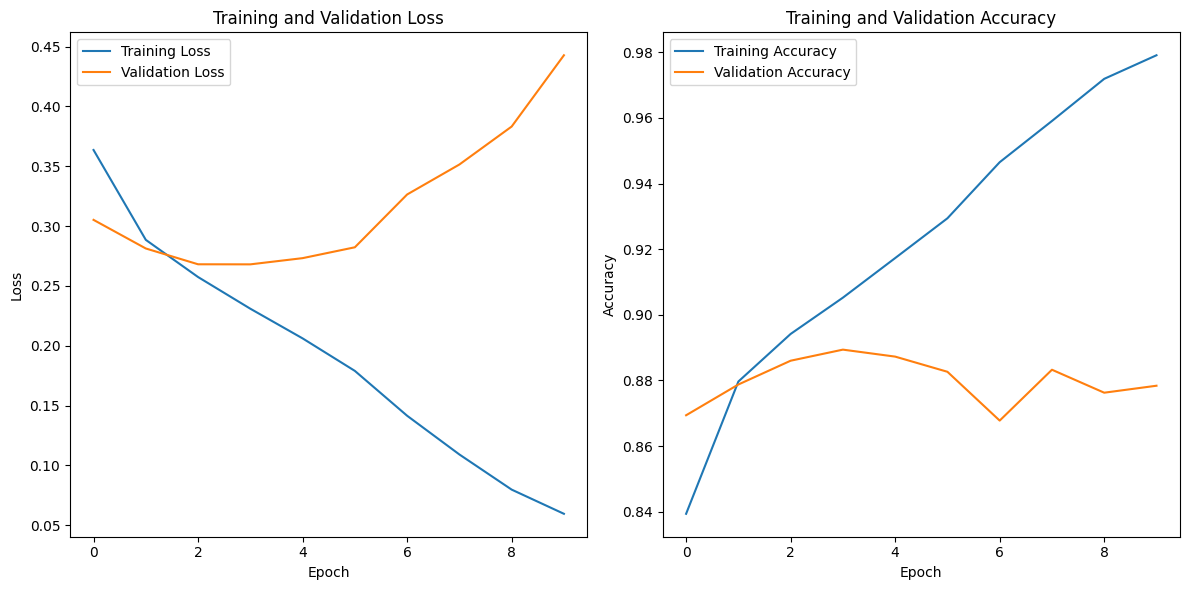

<Figure size 640x480 with 0 Axes>

In [168]:
import matplotlib.pyplot as plt
#Plotting the error
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/My Drive/imbd_senti_analysis_spacy_model_history.png')

In [169]:
#Lets see a complete report
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4961
           1       0.89      0.85      0.87      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [196]:
#Lets create a function for predicting positive, neutral and negative sentiment of a review based on the model
def predict_sentiment(review):
  #First preprocess and padding it
  preprocessed_review = preprocess_text_spacy(review.lower())
  sequence = tokenizer.texts_to_sequences([preprocessed_review])
  padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
  print("Review:" ,preprocessed_review)

  #Predict the sentiment
  sentiment_prediction = model.predict(padded_sequence)
  print("Prediction :",sentiment_prediction)
  if sentiment_prediction > 0.70:
    return 'Positive'
  elif sentiment_prediction < 0.40:
    return 'Negative'
  else:
    return 'Mixed'




In [211]:
##Now give a review
text="not"
print(predict_sentiment(text))

Review: 
1/1 [==============================] - 0s 31ms/step
Prediction : [[0.9794794]]
Positive


In [206]:
word_to_check = 'superb'
if word_to_check in tokenizer.word_index:
    print(f"'{word_to_check}' is present in the tokenizer.")
else:
    print(f"'{word_to_check}' is not present in the tokenizer.")

'superb' is present in the tokenizer.


**Making some Observations**

In [202]:
#Lets play with embedding just for fun
#Lets find top 10 similar words to some given word
word = 'poor'
print(word)
similar_words = word2vec_model.wv.most_similar(word, topn=100)
for word, similarity in similar_words:
    print(f"{word}: {similarity}")


poor
lousy: 0.6958509683609009
horrible: 0.6953840851783752
atrocious: 0.6897918581962585
terrible: 0.6843000650405884
horrid: 0.6769236922264099
weak: 0.6539043188095093
dreadful: 0.648597002029419
horrendous: 0.6394599080085754
lazy: 0.6369398832321167
awful: 0.6256873607635498
abysmal: 0.6205331087112427
amateurish: 0.6194097399711609
amateur: 0.6185564398765564
decent: 0.6161336898803711
pathetic: 0.6085513830184937
dire: 0.5999985933303833
excuse: 0.5964639782905579
wooden: 0.5920049548149109
shoddy: 0.5915446877479553
bland: 0.5915390849113464
appalling: 0.5914743542671204
bad: 0.5900960564613342
worse: 0.584238588809967
lame: 0.5792130827903748
mediocre: 0.5712825655937195
worthless: 0.5701079368591309
pitiful: 0.5684936046600342
boor: 0.5647783279418945
the: 0.5644556879997253
dodgy: 0.5614578723907471
crummy: 0.5613453388214111
stiff: 0.5601406693458557
adequate: 0.5533673167228699
acceptable: 0.5513162612915039
lameinator: 0.5483690500259399
orkan: 0.5477536916732788
lament